In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import date, timedelta
import torch
import torch.nn as nn

In [2]:
data = pd.read_csv('clean.csv')

In [3]:
data

,date,AQI,latitude,longitude
0,2023-04-01 00:00:00,45.765,27.889417,71.375264
1,2023-04-01 01:00:00,46.520,27.889417,71.375264
2,2023-04-01 02:00:00,47.640,27.889417,71.375264
3,2023-04-01 03:00:00,49.330,27.889417,71.375264
4,2023-04-01 04:00:00,51.210,27.889417,71.375264
...,...,...,...,...
9236,2024-04-19 20:00:00,64.075,27.889417,71.375264
9237,2024-04-19 21:00:00,64.950,27.889417,71.375264
9238,2024-04-19 22:00:00,63.735,27.889417,71.375264
9239,2024-04-19 23:00:00,61.845,27.889417,71.375264


In [4]:
data = data[['date', 'AQI']]
data

,date,AQI
0,2023-04-01 00:00:00,45.765
1,2023-04-01 01:00:00,46.520
2,2023-04-01 02:00:00,47.640
3,2023-04-01 03:00:00,49.330
4,2023-04-01 04:00:00,51.210
...,...,...
9236,2024-04-19 20:00:00,64.075
9237,2024-04-19 21:00:00,64.950
9238,2024-04-19 22:00:00,63.735
9239,2024-04-19 23:00:00,61.845


In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

C:\Users\timmy\AppData\Local\Temp\ipykernel_15764\3395756933.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])


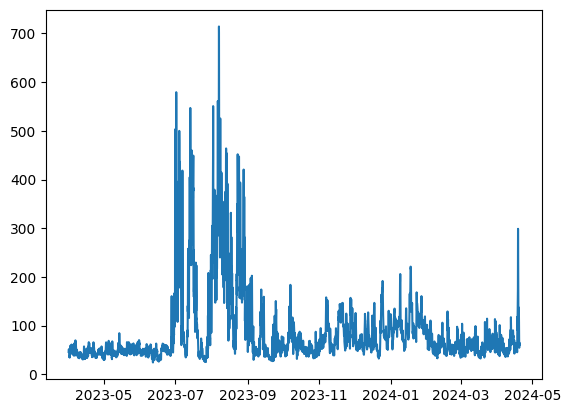

In [6]:
data['date'] = pd.to_datetime(data['date'])

plt.plot(data['date'], data['AQI'])

In [7]:
from copy import deepcopy as dc

def prepare_data(df, n_steps):
  df = dc(df)
  df['date'] = pd.to_datetime(df['date'])

  df.set_index('date', inplace=True)

  for i in range(1, n_steps+1):
    df[f"AQI(t-{i})"] = df['AQI'].shift(i)

  df.dropna(inplace=True)

  return df

lookback = 7
shifted_df = prepare_data(data, lookback)
shifted_df

,AQI,AQI(t-1),AQI(t-2),AQI(t-3),AQI(t-4),AQI(t-5),AQI(t-6),AQI(t-7)
date,,,,,,,,
2023-04-01 07:00:00,47.205,49.650,51.400,51.210,49.330,47.640,46.520,45.765
2023-04-01 08:00:00,44.425,47.205,49.650,51.400,51.210,49.330,47.640,46.520
2023-04-01 09:00:00,42.035,44.425,47.205,49.650,51.400,51.210,49.330,47.640
2023-04-01 10:00:00,40.915,42.035,44.425,47.205,49.650,51.400,51.210,49.330
2023-04-01 11:00:00,40.240,40.915,42.035,44.425,47.205,49.650,51.400,51.210
...,...,...,...,...,...,...,...,...
2024-04-19 20:00:00,64.075,61.375,57.480,54.325,55.820,68.255,86.095,105.880
2024-04-19 21:00:00,64.950,64.075,61.375,57.480,54.325,55.820,68.255,86.095
2024-04-19 22:00:00,63.735,64.950,64.075,61.375,57.480,54.325,55.820,68.255


In [8]:
# converting to an array
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[47.205, 49.65 , 51.4  , ..., 47.64 , 46.52 , 45.765],
       [44.425, 47.205, 49.65 , ..., 49.33 , 47.64 , 46.52 ],
       [42.035, 44.425, 47.205, ..., 51.21 , 49.33 , 47.64 ],
       ...,
       [63.735, 64.95 , 64.075, ..., 54.325, 55.82 , 68.255],
       [61.845, 63.735, 64.95 , ..., 57.48 , 54.325, 55.82 ],
       [60.765, 61.845, 63.735, ..., 61.375, 57.48 , 54.325]])

In [9]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((9234, 7), (9234,))

In [10]:
X = dc(np.flip(X, axis=1))
X

array([[45.765, 46.52 , 47.64 , ..., 51.21 , 51.4  , 49.65 ],
       [46.52 , 47.64 , 49.33 , ..., 51.4  , 49.65 , 47.205],
       [47.64 , 49.33 , 51.21 , ..., 49.65 , 47.205, 44.425],
       ...,
       [68.255, 55.82 , 54.325, ..., 61.375, 64.075, 64.95 ],
       [55.82 , 54.325, 57.48 , ..., 64.075, 64.95 , 63.735],
       [54.325, 57.48 , 61.375, ..., 64.95 , 63.735, 61.845]])

In [11]:
# scaling the data
from sklearn.preprocessing import StandardScaler

data_scaler = StandardScaler()
target_scaler = StandardScaler()
X = data_scaler.fit_transform(X)
y = target_scaler.fit_transform(y.reshape(-1, 1))


In [12]:
# saving the scaler
import joblib

joblib.dump(data_scaler, 'data_scaler.pkl')
joblib.dump(target_scaler, 'target_scaler.pkl')

['target_scaler.pkl']

In [13]:
# loading the scaler
data_scaler = joblib.load('data_scaler.pkl')
target_scaler = joblib.load('target_scaler.pkl')

In [14]:
split_index = int(len(X) * 0.98)

split_index

9049

In [15]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9049, 7), (185, 7), (9049, 1), (185, 1))

In [16]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9049, 7, 1), (185, 7, 1), (9049, 1), (185, 1))

In [17]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([9049, 7, 1]),
 torch.Size([185, 7, 1]),
 torch.Size([9049, 1]),
 torch.Size([185, 1]))

In [18]:
# Creating a dataset
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [19]:
train_dataset

In [20]:
# Data Loader
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [22]:
# LSTM Model


class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers

    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out



In [23]:
model = LSTM(1, 12, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 12, batch_first=True)
  (fc): Linear(in_features=12, out_features=1, bias=True)
)

In [24]:
def train_one_epoch():
  model.train(True)
  print(f'Epoch: {epoch +1 }')

  running_loss = 0.0

  for batch_index, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    output = model(x_batch)
    loss = loss_function(output, y_batch)
    running_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_index % 100==99: # printing every 100 batch
      avg_loss_across_batches = running_loss/100
      print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                  avg_loss_across_batches))
      running_loss = 0.0
  print()

In [25]:
def validate_one_epoch():
  model.train(False)
  running_loss = 0.0

  for batch_index, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
      output = model(x_batch)
      loss = loss_function(output, y_batch)
      running_loss += loss.item()

  avg_loss_across_batches = running_loss / len(test_loader)

  print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
  print('***************************************************')
  print()

In [26]:
learning_rate = 0.0001
num_epochs = 50
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 1.237
Batch 200, Loss: 0.962
Batch 300, Loss: 1.216
Batch 400, Loss: 0.972
Batch 500, Loss: 0.827

Val Loss: 0.315
***************************************************

Epoch: 2
Batch 100, Loss: 0.772
Batch 200, Loss: 0.737
Batch 300, Loss: 0.760
Batch 400, Loss: 0.485
Batch 500, Loss: 0.543

Val Loss: 0.127
***************************************************

Epoch: 3
Batch 100, Loss: 0.437
Batch 200, Loss: 0.359
Batch 300, Loss: 0.309
Batch 400, Loss: 0.228
Batch 500, Loss: 0.210

Val Loss: 0.092
***************************************************

Epoch: 4
Batch 100, Loss: 0.281
Batch 200, Loss: 0.253
Batch 300, Loss: 0.190
Batch 400, Loss: 0.181
Batch 500, Loss: 0.195

Val Loss: 0.096
***************************************************

Epoch: 5
Batch 100, Loss: 0.199
Batch 200, Loss: 0.160
Batch 300, Loss: 0.227
Batch 400, Loss: 0.198
Batch 500, Loss: 0.128

Val Loss: 0.093
***************************************************

Epoch: 6
Batch 100, Loss: 0.12

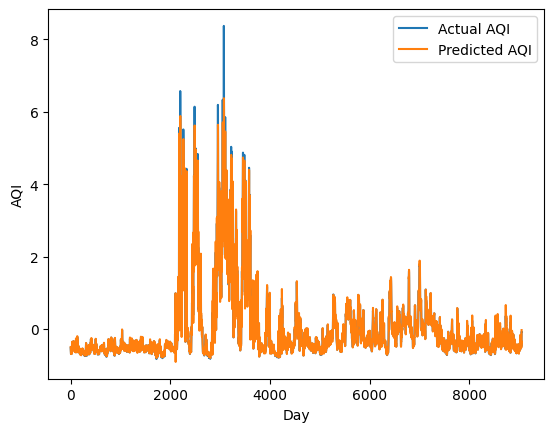

In [27]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual AQI')
plt.plot(predicted, label='Predicted AQI')
plt.xlabel('Day')
plt.ylabel('AQI')
plt.legend()
plt.show()


In [28]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = target_scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([49.073728  , 46.27830552, 43.48025289, ..., 66.73076956,
       79.36029109, 84.12113332])

In [29]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = target_scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([47.20500183, 44.42499789, 42.03499777, ..., 74.85000025,
       80.87500012, 80.70999997])

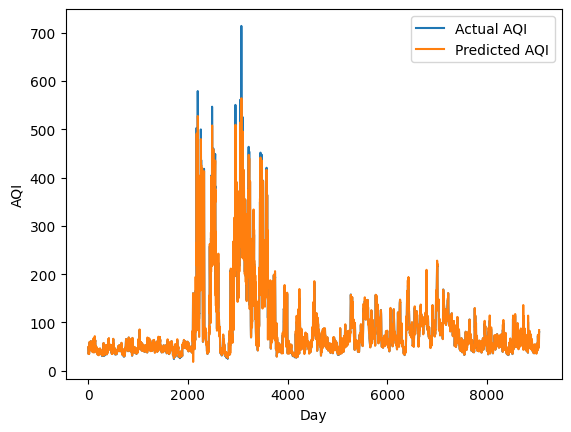

In [30]:
plt.plot(new_y_train, label='Actual AQI')
plt.plot(train_predictions, label='Predicted AQI')
plt.xlabel('Day')
plt.ylabel('AQI')
plt.legend()
plt.show()


In [31]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = target_scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([ 80.49354315,  76.88244506,  77.85320075,  85.23571047,
        95.07583021,  68.15150351,  91.27309169, 119.35810581,
       123.43416906, 102.43625656,  90.75453288,  87.33432374,
        82.21569695,  78.76321711,  73.66887443,  64.79458556,
        59.45760763,  59.75839232,  61.18605947,  60.37008416,
        61.66003108,  67.79322692,  76.05386027,  76.40681843,
        72.05396608,  68.4304911 ,  68.44865162,  73.14781519,
        83.78221155,  69.40043718,  73.04182665,  75.28155073,
        72.34609097,  69.68660846,  67.30292427,  64.82518112,
        63.12199298,  62.96774935,  64.69920706,  68.14202068,
        70.25363259,  62.50449513,  61.82220539,  63.45117695,
        68.08892129,  76.22846068,  83.98878296,  86.89479449,
        87.70441138,  88.81917416,  89.82569175,  89.6728303 ,
        88.13001384,  86.59242635,  84.86401701,  79.64606427,
        75.98943069,  77.03639346,  77.7959325 ,  77.89504598,
        77.52515739,  78.16197427,  77.54238305,  76.19

In [32]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = target_scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([ 78.87000017,  78.9799999 ,  83.815     ,  91.5250001 ,
        73.88500024,  89.29500012, 108.34500004, 117.08499948,
       108.11500112,  98.90999962,  92.12499999,  84.97999998,
        80.33499982,  75.2250004 ,  67.51999948,  61.98499922,
        60.73999959,  61.16500042,  60.57999917,  61.73499912,
        66.59499957,  73.50500036,  75.2650005 ,  73.27500031,
        70.48500027,  69.65499977,  72.5749996 ,  80.68500018,
        71.61500043,  74.37499985,  75.04499992,  73.09499984,
        71.07999987,  68.73499959,  66.22000054,  64.29999998,
        63.66499915,  64.72999943,  67.46000044,  69.56500009,
        64.28499966,  63.43500023,  63.84500074,  67.24999933,
        73.88999997,  80.92999998,  85.00999999,  87.28000001,
        88.93500001,  90.03000009,  90.15000012,  89.09499987,
        87.72500005,  86.005     ,  81.67999999,  78.05999973,
        77.67500011,  77.70999993,  77.88500011,  77.80000016,
        78.34500019,  77.96499976,  76.99500001,  77.79

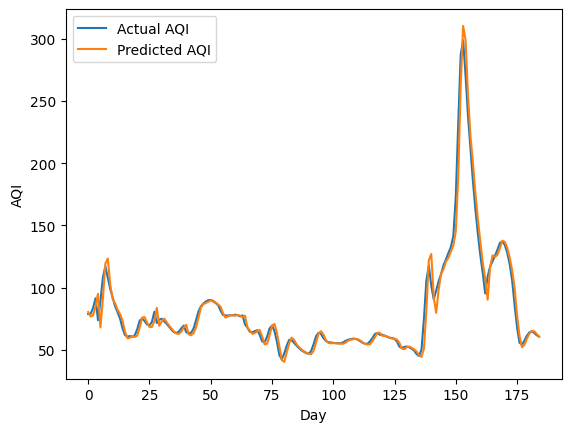

In [33]:
plt.plot(new_y_test, label='Actual AQI')
plt.plot(test_predictions, label='Predicted AQI')
plt.xlabel('Day')
plt.ylabel('AQI')
plt.legend()
plt.show()


In [34]:
# Saving the model
model.eval()
torch.save(model, "new_1_lstm_model.pt")  
# def save_model(model, filename):
#   """Saves the model's state dictionary to a file.

#   Args:
#       model (nn.Module): The model to save.
#       filename (str): The filename to save the model state dictionary to.
#   """
#   model.eval()  # Set the model to evaluation mode (optional but recommended)
#   torch.save(model.state_dict(), filename)

# # Example usage:
# model = LSTM(1, 12, 1)
# model.to(device)
# save_model(model, "new_lstm_model.pt")

In [35]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_function,
            }, 'model.pt')


# model = LSTM(1, 4, 2)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# checkpoint = torch.load('model.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

model = torch.load('new_1_lstm_model.pt')
for param in model.lstm.parameters():  # Freeze LSTM layer weights (example)
  param.requires_grad = False


# model.eval()
# # - or -
# model.train()

In [36]:
def model_data(df):
    df['date'] = pd.to_datetime(df['date'])
    shifted_df = prepare_data(df, lookback)
    shifted_df_as_np = shifted_df.to_numpy()
    # preparing the data for the model
    X = shifted_df_as_np[:, 1:]
    y = shifted_df_as_np[:, 0]
    # loading the scaler
    data_scaler = joblib.load('data_scaler.pkl')
    target_scaler = joblib.load('target_scaler.pkl')
    # scaling the data
    scaled_data = data_scaler.transform(X)
    # preparing the data for the model
    X = scaled_data
    y = target_scaler.transform(y.reshape(-1, 1))
    # flipping X
    X = dc(np.flip(X, axis=1))
    # reshaping X and y
    X_ = X.reshape((-1, lookback, 1))
    y_ = y.reshape((-1, 1))
    # converting to tensor
    X_ = torch.tensor(X_).float().to(device)
    y_ = torch.tensor(y_).float().to(device)
    # now using the dataset class
    dataset = TimeSeriesDataset(X_, y_)
    # creating a dataloader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader, X_, y_


df = pd.read_csv('clean.csv')
data, x, y = model_data(df[['date', 'AQI']])


C:\Users\timmy\AppData\Local\Temp\ipykernel_15764\2721844118.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


In [37]:
x.shape

torch.Size([9234, 7, 1])

In [38]:
# finetune the model on thw whole data

def train_one_epoch():
  model.train(True)
  print(f'Epoch: {epoch +1 }')

  running_loss = 0.0

  for batch_index, batch in enumerate(data):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    output = model(x_batch)
    loss = loss_function(output, y_batch)
    running_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_index % 100==99: # printing every 100 batch
      avg_loss_across_batches = running_loss/100
      print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                  avg_loss_across_batches))
      running_loss = 0.0
  print()
  
def validate_one_epoch():
  model.train(False)
  running_loss = 0.0

  for batch_index, batch in enumerate(data):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
      output = model(x_batch)
      loss = loss_function(output, y_batch)
      running_loss += loss.item()

  avg_loss_across_batches = running_loss / len(data)

  print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
  print('***************************************************')
  print()

In [39]:
learning_rate = 0.0001
num_epochs = 5

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1


Batch 100, Loss: 0.001
Batch 200, Loss: 0.082
Batch 300, Loss: 0.028
Batch 400, Loss: 0.002
Batch 500, Loss: 0.002

Val Loss: 0.021
***************************************************

Epoch: 2
Batch 100, Loss: 0.001
Batch 200, Loss: 0.082
Batch 300, Loss: 0.028
Batch 400, Loss: 0.002
Batch 500, Loss: 0.002

Val Loss: 0.021
***************************************************

Epoch: 3
Batch 100, Loss: 0.001
Batch 200, Loss: 0.081
Batch 300, Loss: 0.028
Batch 400, Loss: 0.002
Batch 500, Loss: 0.002

Val Loss: 0.021
***************************************************

Epoch: 4
Batch 100, Loss: 0.001
Batch 200, Loss: 0.081
Batch 300, Loss: 0.028
Batch 400, Loss: 0.002
Batch 500, Loss: 0.002

Val Loss: 0.021
***************************************************

Epoch: 5
Batch 100, Loss: 0.001
Batch 200, Loss: 0.081
Batch 300, Loss: 0.028
Batch 400, Loss: 0.002
Batch 500, Loss: 0.002

Val Loss: 0.021
***************************************************



In [40]:
# Saving the model
model.eval()
torch.save(model, "best_model.pt")  

## Testing section

In [41]:
def prepare_data(df, n_steps):
  df = dc(df)
  df['date'] = pd.to_datetime(df['date'])

  df.set_index('date', inplace=True)

  for i in range(1, n_steps+1):
    df[f"AQI(t-{i})"] = df['AQI'].shift(i)

  df.dropna(inplace=True)

  return df

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
batch_size = 16

In [42]:
def model_data(df):
    df['date'] = pd.to_datetime(df['date'])
    shifted_df = prepare_data(df, lookback)
    shifted_df_as_np = shifted_df.to_numpy()

    # preparing the data for the model
    X = shifted_df_as_np[:, 1:]
    y = shifted_df_as_np[:, 0]
    # flipping X
    X = dc(np.flip(X, axis=1))
    # loading the scaler
    data_scaler = joblib.load('data_scaler.pkl')
    target_scaler = joblib.load('target_scaler.pkl')
    # scaling the data
    scaled_data = data_scaler.transform(X)
    scald_target = target_scaler.transform(y.reshape(-1, 1))
    
    # reshaping X and y
    X_ = scaled_data.reshape((-1, lookback, 1))
    y_ = scald_target.reshape((-1, 1))
    # converting to tensor
    X_ = torch.tensor(X_).float().to(device)
    y_ = torch.tensor(y_).float().to(device)
    # now using the dataset class
    dataset = TimeSeriesDataset(X_, y_)
    # creating a dataloader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader, X_, y_

# model loading function
def load_model():
    model = torch.load('best_model.pt')
    for param in model.lstm.parameters():
        param.requires_grad = False
    return model


def predict(dataloader):
    model = load_model()
    model.eval()
    predictions = []
    y_ = []
    with torch.no_grad():
        for X, y in dataloader:
            y_pred = model(X)
            predictions.append(y_pred)
            y_.append(y)
    return predictions, y_

In [43]:
import pandas as pd
def create_hourly_increments(date):
    # getting the next date
    date = pd.to_datetime(date)
    next_date = date + pd.DateOffset(days=4)
    return pd.date_range(start=date, end=next_date,  freq='H')
    
def get_date_data(date):
    df = pd.read_csv('clean.csv')
    df['date'] = pd.to_datetime(df['date'])
    # convert date to datetime
    date_dt = pd.to_datetime(date)
    # getting the hourly increments for the selected date
    hourly_df = pd.DataFrame({'date': create_hourly_increments(date)})
    data_ = df[df['date'].isin(hourly_df['date'].astype(str).values.tolist())]
    return data_

d = get_date_data('2024-04-17')


C:\Users\timmy\AppData\Local\Temp\ipykernel_15764\1799618833.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.date_range(start=date, end=next_date,  freq='H')
C:\Users\timmy\AppData\Local\Temp\ipykernel_15764\1799618833.py:15: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  data_ = df[df['date'].isin(hourly_df['date'].astype(str).values.tolist())]


In [44]:
d

,date,AQI,latitude,longitude
9168,2024-04-17 00:00:00,55.730,27.889417,71.375264
9169,2024-04-17 01:00:00,54.995,27.889417,71.375264
9170,2024-04-17 02:00:00,54.990,27.889417,71.375264
9171,2024-04-17 03:00:00,56.955,27.889417,71.375264
9172,2024-04-17 04:00:00,59.580,27.889417,71.375264
...,...,...,...,...
9236,2024-04-19 20:00:00,64.075,27.889417,71.375264
9237,2024-04-19 21:00:00,64.950,27.889417,71.375264
9238,2024-04-19 22:00:00,63.735,27.889417,71.375264
9239,2024-04-19 23:00:00,61.845,27.889417,71.375264


In [45]:
len(d)

73

In [46]:
loader, x, y = model_data(d[['date', 'AQI']])

C:\Users\timmy\AppData\Local\Temp\ipykernel_15764\3198408548.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


In [61]:
model = load_model()
model.eval()
model

LSTM(
  (lstm): LSTM(1, 12, batch_first=True)
  (fc): Linear(in_features=12, out_features=1, bias=True)
)

In [48]:
predictions, y = predict(loader)

In [49]:
# a function for making plot
def make_plot(predictions, y):
    scaler = joblib.load('target_scaler.pkl')   
    predictions = torch.cat(predictions).cpu().numpy().flatten()
    y = torch.cat(y).cpu().numpy().flatten()

    dummies = np.zeros((len(predictions), lookback+1))
    dummies[:, 0] = predictions
    dummies = scaler.inverse_transform(dummies)

    predictions = dc(dummies[:, 0])

    dummies = np.zeros((len(y), lookback+1))
    dummies[:, 0] = y.flatten()
    dummies = scaler.inverse_transform(dummies)

    new_y = dc(dummies[:, 0])

    plt.plot(new_y, label='Actual AQI')
    plt.plot(predictions, label='Predicted AQI')
    plt.xlabel('Hour')
    plt.ylabel('AQI')
    plt.legend()
    plt.show()

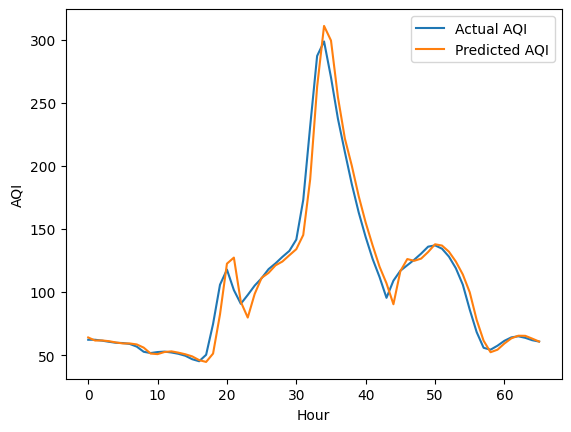

In [50]:
make_plot(predictions, y)

In [51]:
data_scaler = joblib.load('data_scaler.pkl')
data_scaler

StandardScaler()

In [62]:
def predict_today(n=24):
    # loading the database
    data = pd.read_csv('clean.csv')
    # getting today's date
    today_date = date.today()
    today_date = pd.to_datetime(today_date)
    # get last date in the data
    last_date = data['date'].iloc[-1]
    # converting both to time and getting the total hours between them
    last_date = pd.to_datetime(last_date)
    hours_diff = (today_date - last_date).total_seconds() / 3600
    aqi_data = data['AQI'].values.tolist()
    model = load_model()
    data_scaler = joblib.load('data_scaler.pkl')
    target_scaler = joblib.load('target_scaler.pkl')
    lookback = 7
    # ensureing we are just collecting the last 6 values
    current_data = aqi_data[-lookback:]
    predictions = []
    model.eval()
    for _ in range(int(hours_diff)):
        # Ensure current_data has the required length
        if len(current_data) != lookback:
            raise ValueError(f"Current data must have length {lookback}")

        # Prepare data for the model (scaling and reshaping)
        current_data_np = np.array([current_data])  # Assuming data is a list
        scaled_data = data_scaler.transform(current_data_np)
        X = scaled_data.reshape((1, lookback, 1))
        X_ = torch.tensor(X).float().to(device)

        # Make prediction
        with torch.no_grad():
            y_pred = model(X_)

        # Inverse scaling of the predicted value (assuming single value prediction)
        predicted_value = target_scaler.inverse_transform(y_pred.cpu().detach().numpy())[0][0]

        # Update current_data for the next iteration
        current_data.append(predicted_value)
        current_data = current_data[-lookback:]  # Keep only the last lookback values

        # Append the prediction to the final list
        predictions.append(predicted_value)

    return predictions[-24:]


In [63]:
pred = predict_today()
pred

[50.46204,
 50.46055,
 50.459137,
 50.457794,
 50.456524,
 50.455315,
 50.454174,
 50.453087,
 50.45205,
 50.451077,
 50.450146,
 50.44927,
 50.448437,
 50.447647,
 50.44689,
 50.446182,
 50.445507,
 50.444866,
 50.44426,
 50.443676,
 50.443123,
 50.442604,
 50.442112,
 50.441647]

In [64]:
# predicting for thr last seven days
def predict_last_seven_days():
    # getting the data
    data = pd.read_csv('clean.csv')
    # converting date to the right format
    data['date'] = pd.to_datetime(data['date'])
    # today's date
    today_date = date.today()
    # last seven days
    last_seven_days = today_date - timedelta(days=7)
    # converting to datetime
    today_date = pd.to_datetime(today_date)
    last_seven_days = pd.to_datetime(last_seven_days)
    # caalculating the hours difference
    hours_diff = (today_date - last_seven_days).days * 24
    # the prev day before the last seven days data
    previous_day_hrs = hours_diff + 24 
    # getting the data
    aqi_data = data['AQI'].values.tolist()[-previous_day_hrs:-hours_diff]
    # loading model
    model = load_model()
    # loading scalers
    data_scaler = joblib.load('data_scaler.pkl')
    target_scaler = joblib.load('target_scaler.pkl')
    # lookback
    lookback = 7
    # current data
    current_data = aqi_data[-lookback:]
    # predictions
    predictions = []
    # loop to make predictions
    for _ in range(hours_diff):
        if len(current_data) != lookback:
            raise ValueError(f"Current data must have length {lookback}")

        current_data_np = np.array([current_data])
        scaled_data = data_scaler.transform(current_data_np)
        X = scaled_data.reshape((1, lookback, 1))
        X_ = torch.tensor(X).float().to(device)

        with torch.no_grad():
            y_pred = model(X_)

        predicted_value = target_scaler.inverse_transform(y_pred.cpu().detach().numpy())[0][0]

        current_data.append(predicted_value)
        current_data = current_data[-lookback:]

        predictions.append(predicted_value)

    return predictions[-24*7:]

In [65]:
predict_last_seven_days()

[59.94738,
 59.8379,
 59.78784,
 59.680717,
 59.500896,
 59.26785,
 59.004913,
 58.73,
 58.45331,
 58.179924,
 57.9119,
 57.649876,
 57.393932,
 57.143993,
 56.9,
 56.661915,
 56.429752,
 56.203526,
 55.98324,
 55.768917,
 55.56057,
 55.358173,
 55.161716,
 54.971176,
 54.786503,
 54.60764,
 54.434536,
 54.267128,
 54.10534,
 53.949078,
 53.798264,
 53.652798,
 53.512573,
 53.377495,
 53.247456,
 53.122326,
 53.00199,
 52.886333,
 52.775227,
 52.668564,
 52.566193,
 52.468002,
 52.373863,
 52.28365,
 52.19723,
 52.11449,
 52.035297,
 51.959522,
 51.887043,
 51.81776,
 51.75154,
 51.688282,
 51.627865,
 51.570183,
 51.51512,
 51.46258,
 51.41246,
 51.36466,
 51.319084,
 51.275635,
 51.234226,
 51.19477,
 51.15717,
 51.12135,
 51.08725,
 51.054783,
 51.02388,
 50.994465,
 50.966473,
 50.939842,
 50.91451,
 50.890408,
 50.867477,
 50.845676,
 50.824944,
 50.805237,
 50.786495,
 50.76869,
 50.75176,
 50.735664,
 50.720375,
 50.70585,
 50.692047,
 50.678932,
 50.666477,
 50.654644,
 50.6434

In [68]:
# next seven days prediction
def predict_next_seven_days():
    # loading the database
    data = pd.read_csv('clean.csv')
    # getting today's date
    today_date = date.today()
    today_date = pd.to_datetime(today_date)
    # get last date in the data
    last_date = data['date'].iloc[-1]
    # converting both to time and getting the total hours between them
    last_date = pd.to_datetime(last_date)
    hours_diff = (today_date - last_date).total_seconds() / 3600
    # adding 168 to the hours diff
    hours_diff += 168
    aqi_data = data['AQI'].values.tolist()
    model = load_model()
    model.eval
    data_scaler = joblib.load('data_scaler.pkl')
    target_scaler = joblib.load('target_scaler.pkl')
    lookback = 7
    # ensureing we are just collecting the last 6 values
    current_data = aqi_data[-lookback:]
    predictions = []
    for _ in range(int(hours_diff)):
        # Ensure current_data has the required length
        if len(current_data) != lookback:
            raise ValueError(f"Current data must have length {lookback}")

        # Prepare data for the model (scaling and reshaping)
        current_data_np = np.array([current_data])  # Assuming data is a list
        scaled_data = data_scaler.transform(current_data_np)
        X = scaled_data.reshape((1, lookback, 1))
        X_ = torch.tensor(X).float().to(device)

        # Make prediction
        with torch.no_grad():
            y_pred = model(X_)

        # Inverse scaling of the predicted value (assuming single value prediction)
        predicted_value = target_scaler.inverse_transform(y_pred.cpu().detach().numpy())[0][0]

        # Update current_data for the next iteration
        current_data.append(predicted_value)
        current_data = current_data[-lookback:]  # Keep only the last lookback values

        # Append the prediction to the final list
        predictions.append(predicted_value)

    return predictions[-168:]

In [69]:
predict_next_seven_days()

[50.4412,
 50.440777,
 50.440376,
 50.439995,
 50.439632,
 50.439285,
 50.438957,
 50.43864,
 50.438347,
 50.438065,
 50.437798,
 50.437553,
 50.43732,
 50.437096,
 50.436886,
 50.43669,
 50.43651,
 50.436333,
 50.43616,
 50.436,
 50.43585,
 50.435696,
 50.435555,
 50.43542,
 50.435295,
 50.435173,
 50.43505,
 50.434944,
 50.43485,
 50.43475,
 50.434654,
 50.43457,
 50.43449,
 50.434402,
 50.43433,
 50.434258,
 50.43419,
 50.434124,
 50.43407,
 50.434013,
 50.433968,
 50.433918,
 50.433872,
 50.43383,
 50.43379,
 50.433746,
 50.433712,
 50.433666,
 50.43362,
 50.43358,
 50.433537,
 50.433502,
 50.433468,
 50.43344,
 50.433414,
 50.433388,
 50.433357,
 50.433334,
 50.433308,
 50.43329,
 50.43326,
 50.433243,
 50.433224,
 50.433205,
 50.43318,
 50.433167,
 50.43315,
 50.433144,
 50.43314,
 50.433132,
 50.43313,
 50.433125,
 50.43312,
 50.433113,
 50.433105,
 50.433094,
 50.43309,
 50.43308,
 50.433075,
 50.433067,
 50.43306,
 50.433052,
 50.43304,
 50.43303,
 50.433014,
 50.43301,
 50.43